In [1]:
## testing multidark
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import h5py
import tables
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os

In [2]:
from pygadgetreader import *

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import timeit

In [5]:
import mpi4py as mpi

In [6]:
datadir = '/global/cscratch1/sd/zzhang13/MultiDark/MDPL2_ROCKSTAR_Halos/z0p00/'

In [7]:
## Import halos with mvir > 5e13
cluster_df = pd.read_csv(datadir + 'clusters_mvir_lgt_5e13.csv')

In [8]:
cluster_df.keys()

Index(['Unnamed: 0', 'scale', 'id', 'pid', 'mvir', 'rvir', 'x', 'y', 'z',
       'M200b', 'M200c', 'M500c'],
      dtype='object')

In [9]:
## Remove the unnamed columne from cluster_df
cluster_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [10]:
import _pickle as pickle
## Read files
file_num = list(range(25))

def read_halo_file(datadir, num):
    file_name = 'mdpl2_rockstar_z0p00_{}.pickle'.format(num)
    with open(datadir+file_name, 'rb') as handle:
        halo_df = pickle.load(handle)
    return halo_df

In [11]:
halo_df =  read_halo_file(datadir, 0)
len(halo_df)

ValueError: unsupported pickle protocol: 5

## Make clusters into H5PY files 

In [10]:
import h5py
from os import path

In [11]:
filename = datadir+'clusters_multidark.hdf5'

if path.exists(filename):
    cl_h5py = h5py.File(filename,'r+')    

else:
    cl_h5py = h5py.File(filename,'w')

In [12]:
cl_h5py.name
list(cl_h5py.keys())

['mvir:1e+14-5e+14',
 'mvir:1e+15-5e+15',
 'mvir:5e+13-1e+14',
 'mvir:5e+14-1e+15']

### Creating groups by MVIR mass bins

In [42]:
cl_keys = cluster_df.keys()

In [16]:
## Cluster binning attributes
mvir_bins = [5e13,1e14,5e14,1e15,5e15]
r_range = np.logspace(-1,1,20)
cl_attrs = cluster_df.keys()

In [92]:
from tqdm import tqdm

## Find clusters in mvir bins
for i in tqdm(range(len(mvir_bins)-1)):
    mvir_low = mvir_bins[i]; mvir_high = mvir_bins[i+1]
    
    #masking
    mask = (cluster_df.mvir >= mvir_low) & (cluster_df.mvir < mvir_high)
    cur_df = cluster_df[mask]
    
    ##Make outer group
    group_name = 'mvir:{:.1g}-{:.1g}'.format(mvir_low, mvir_high) 
    
    ##Create new group if it doens't exist
    if group_name not in cl_h5py:
        cl_h5py.create_group(group_name)
        cur_grp = cl_h5py[group_name]
    
        for k in cl_keys:
            cur_grp[k] = cur_df[k].to_numpy()
        
        ##Add additional datasets
        cur_grp.create_dataset('DS_dz50', (len(cur_df), len(r_range)-1))
        cur_grp.create_dataset('DS_dz100', (len(cur_df), len(r_range)-1))
        cur_grp.create_dataset('DS_dz200', (len(cur_df), len(r_range)-1))
        cur_grp.create_dataset('r_range_norm', (len(cur_df), len(r_range)))

100%|██████████| 4/4 [00:00<00:00, 34.03it/s]


In [15]:
mvir_bins = [5e13,1e14,5e14,1e15,5e15]
group_name = 'mvir:{:.1g}-{:.1g}'.format(mvir_bins[0], mvir_bins[1])
print(group_name)

mvir:5e+13-1e+14


In [94]:
grp = cl_h5py['mvir:5e+13-1e+14'].keys()
print(grp)
print(len(grp))
print(len(cluster_df))

<KeysViewHDF5 ['DS_dz100', 'DS_dz200', 'DS_dz50', 'M200b', 'M200c', 'M500c', 'id', 'mvir', 'pid', 'r_range_norm', 'rvir', 'scale', 'x', 'y', 'z']>
15
71121


## Cluster object

In [120]:
from setup import ptcl_dir, cluster_dir
box_length = 1000

class clusters_obj(object):

    '''
    Initializes the cluster_obj for derivation of cluster properties. 
    
    (x,y,z): The 3D coordinates of the cluster in Mpc/h
    M: Mass of the cluster in Msun/h. Could be Mvir, M200c/M200m, M500c/M500m. 
    R: The radius of the cluster in Mpc/h to normalize. Could be R200c/R200m or R500c/R500m. 
    r_range_norm: the radii range in Mpc/h over the R_vir (or R200c/R200m) for clusters
    dz: Projection depth in Mpc/h. 
    '''
    def __init__(self, x, y, z, M, R, r_range_norm, dz=200):
        r_bin_center = (r_range_norm[0:-1] + r_range_norm[1:])/2
        
        self.x = x; self.y = y; self.z = z
        self.M = M
        self.R = R
        self.dz = dz
        self.Sigma = np.zeros((len(x), len(r_bin_center)))     #Sigma
        self.DS = np.zeros((len(x), len(r_bin_center)))        #Delta Sigma
        self.r_range = r_range_norm*R[:,np.newaxis] #Broadcasted to (N,len(r_range))
        return
    
    '''
    Computes the Surface Density of all the clusters. This part make parellizable.
    '''
    def compute_Sigma_all(self):
        
        ptcl_files = glob(ptcl_dir() + 'snap_130.*')
        for file in ptcl_files:
            ptcl = readsnap(file, 'pos', 'dm', suppress=1, single=True)
            
            ##Calculate the contribution of the particle file for each cluster
            ## This part of the code needs fixing. 
            
            start = timer()
            for i in range(len(self.x)):
                #Sigma_cluster_file = self.__compute_Sigma_percluster_perfile(ptcl, self.x[i], self. y[i], self.z[i], self.r_range[i], self.dz)
                r_range = self.r_range[i]
                sigma = np.zeros(len(r_range)-1)
        
                ##Periodic boundary condition for annulus. Halos are conditions at [0,1000] Mpc boundaries.       
                dx_sqr = np.asarray([(ptcl[:,0]-x[i])**2, (ptcl[:,0]-x[i]+box_length)**2, (ptcl[:,0]-x[i]-box_length)**2]).min(0)
                dy_sqr = np.asarray([(ptcl[:,1]-y[i])**2, (ptcl[:,1]-y[i]+box_length)**2, (ptcl[:,1]-y[i]-box_length)**2]).min(0)
                dz_min = np.asarray([np.abs(ptcl[:,2]-z[i]), np.abs(ptcl[:,2]-z[i]+box_length), np.abs(ptcl[:,2]-z[i]-box_length)]).min(0)

                for j in range(len(r_range)-1):
                    #radius for annulus
                    dr = r_range[j+1] - r_range[j]
                    r_cur = r_range[j]

                    #Masking
                    mask = dx_sqr + dy_sqr <= (r_cur+dr)**2
                    mask &= dz_min < self.dz

                    #Building an annulus
                    annulus_df = ptcl[mask]

                    #Find 2D density within the annulus
                    area = np.pi * ((r_cur+dr)**2 - (r_cur)**2.)

                    m_tot = len(annulus_df)*ptcl_mass

                    #self.mass_dz50[cluster_ind] += m_tot
                    #self.mass_dz100[cluster_ind] += m_tot
                    #self.mass_dz200[cluster_ind] += m_tot
                    #delta_sigma[i] = m_tot/area

                    sigma[j] = m_tot/area
                
                self.Sigma[i] += sigma
            end = timer()
            print("Elapsed time: ", end-start)
            
        return
    
    '''
    Internal function to compute
    '''
    def __compute_Sigma_percluster_perfile(self, ptcl, x, y, z, r_range, dz):
        sigma = np.zeros(len(r_range)-1)
        
        ##Periodic boundary condition for annulus. Halos are conditions at [0,1000] Mpc boundaries.       
        dx_sqr = np.asarray([(ptcl[:,0]-x)**2, (ptcl[:,0]-x+box_length)**2, (ptcl[:,0]-x-box_length)**2]).min(0)
        dy_sqr = np.asarray([(ptcl[:,1]-y)**2, (ptcl[:,1]-y+box_length)**2, (ptcl[:,1]-y-box_length)**2]).min(0)
        dz_min = np.asarray([np.abs(ptcl[:,2]-z), np.abs(ptcl[:,2]-z+box_length), np.abs(ptcl[:,2]-z-box_length)]).min(0)

        for i in range(len(r_range)-1):
            #radius for annulus
            dr = r_range[i+1] - r_range[i]
            r_cur = r_range[i]

            #Masking
            mask = dx_sqr + dy_sqr <= (r_cur+dr)**2
            mask &= dz_min < dz

            #Building an annulus
            annulus_df = ptcl[mask]

            #Find 2D density within the annulus
            area = np.pi * ((r_cur+dr)**2 - (r_cur)**2.)
            
            m_tot = len(annulus_df)*ptcl_mass

            #self.mass_dz50[cluster_ind] += m_tot
            #self.mass_dz100[cluster_ind] += m_tot
            #self.mass_dz200[cluster_ind] += m_tot
            #delta_sigma[i] = m_tot/area
    
            sigma[i] = m_tot/area
        return sigma
    
    def get_Sigma(self):
        return self.Sigma
    

## Compute DS

In [2]:
import mpi4py
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [ ]:
ptcl_files = glob(ptcl_dir() + 'snap_130.*')
        for file in ptcl_files:
            ptcl = readsnap(file, 'pos', 'dm', suppress=1, single=True)
            
            ##Calculate the contribution of the particle file for each cluster
            ## This part of the code needs fixing. 
            
            start = timer()
            for i in range(len(self.x)):
                #Sigma_cluster_file = self.__compute_Sigma_percluster_perfile(ptcl, self.x[i], self. y[i], self.z[i], self.r_range[i], self.dz)
                r_range = self.r_range[i]
                sigma = np.zeros(len(r_range)-1)
        
                ##Periodic boundary condition for annulus. Halos are conditions at [0,1000] Mpc boundaries.       
                dx_sqr = np.asarray([(ptcl[:,0]-x[i])**2, (ptcl[:,0]-x[i]+box_length)**2, (ptcl[:,0]-x[i]-box_length)**2]).min(0)
                dy_sqr = np.asarray([(ptcl[:,1]-y[i])**2, (ptcl[:,1]-y[i]+box_length)**2, (ptcl[:,1]-y[i]-box_length)**2]).min(0)
                dz_min = np.asarray([np.abs(ptcl[:,2]-z[i]), np.abs(ptcl[:,2]-z[i]+box_length), np.abs(ptcl[:,2]-z[i]-box_length)]).min(0)

                for j in range(len(r_range)-1):
                    #radius for annulus
                    dr = r_range[j+1] - r_range[j]
                    r_cur = r_range[j]

                    #Masking
                    mask = dx_sqr + dy_sqr <= (r_cur+dr)**2
                    mask &= dz_min < self.dz

                    #Building an annulus
                    annulus_df = ptcl[mask]

                    #Find 2D density within the annulus
                    area = np.pi * ((r_cur+dr)**2 - (r_cur)**2.)

                    m_tot = len(annulus_df)*ptcl_mass

                    #self.mass_dz50[cluster_ind] += m_tot
                    #self.mass_dz100[cluster_ind] += m_tot
                    #self.mass_dz200[cluster_ind] += m_tot
                    #delta_sigma[i] = m_tot/area

                    sigma[j] = m_tot/area
                
                self.Sigma[i] += sigma
            end = timer()
            print("Elapsed time: ", end-start)

In [121]:
mvir_low = mvir_bins[0]; mvir_high = mvir_bins[1]
mask = (cluster_df.mvir >= mvir_low) & (cluster_df.mvir < mvir_high)
cur_df = cluster_df[mask]
cur_df = cur_df.iloc[:sample_num] ##Get the first 100 clusters

cur_df.iloc[0]['x']

147.01381

In [ ]:
sample_num=50

for i in tqdm(range(len(mvir_bins)-1)):
    mvir_low = mvir_bins[i]; mvir_high = mvir_bins[i+1]
    
    #masking
    mask = (cluster_df.mvir >= mvir_low) & (cluster_df.mvir < mvir_high)
    cur_df = cluster_df[mask]
    cur_df = cur_df.head(sample_num) ##Get the first 100 clusters
    
    group_name = 'mvir:{:.1g}-{:.1g}'.format(mvir_low, mvir_high)
    cur_grp = cl_h5py[group_name]
    
    #Build cluster object and compute DS
    cl_obj = clusters(cur_df, r_range)
    #cl_obj.compute_DS_dz50()
    #cl_obj.compute_DS_dz100()
    cl_obj.compute_DS_dz200()
    
    #Get DS
    #cur_grp['DS_dz50'][:sample_num] = cl_obj.get_DS_dz50()
    #cur_grp['DS_dz100'][:sample_num] = cl_obj.get_DS_dz100()
    cur_grp['DS_dz200'][:sample_num] = cl_obj.get_DS_dz200()
    
    #Get r_norm
    cur_grp['r_range_norm'][:sample_num] = cl_obj.get_r_range_norm()

mvir:1e+14-5e+14
mvir:1e+15-5e+15
mvir:5e+13-1e+14
mvir:5e+14-1e+15


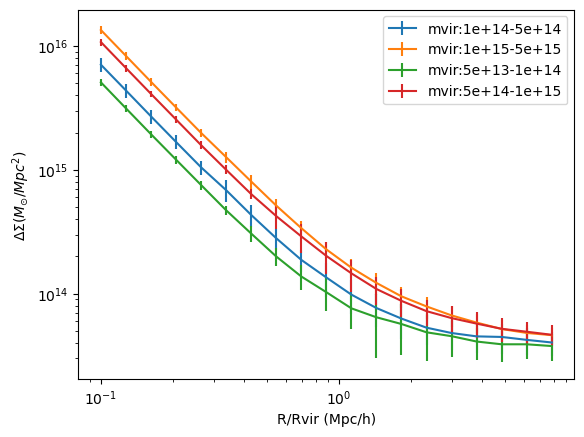

In [17]:
## Computing errors for each of the data points. 
sample_num = 50
## Plot
for grp_name in cl_h5py:
    print(grp_name)
    grp = cl_h5py[grp_name]
    
    error = np.std(grp['DS_dz200'][:sample_num], axis=0)
    plt.errorbar(r_range[:-1], np.mean(grp['DS_dz200'][:sample_num], axis=0), yerr=error, label=grp_name) 
    
plt.yscale('log'); plt.xscale('log')
plt.xlabel('R/Rvir (Mpc/h)')
plt.ylabel(r'$\Delta\Sigma (M_{\odot}/Mpc^2)$ ')
plt.legend()
plt.show()

In [24]:
grp['DS_dz200'].value

array([[ 9.8829957e+15,  6.1000776e+15,  3.7638688e+15, ...,
         3.4013606e+13,  3.3345539e+13,  3.3145752e+13],
       [ 9.8025810e+15,  6.0377888e+15,  3.7198889e+15, ...,
         3.1385631e+13,  3.1492885e+13,  3.4325137e+13],
       [ 1.1378855e+16,  7.0147682e+15,  4.3531222e+15, ...,
         6.6189078e+13,  6.4305387e+13,  6.2390738e+13],
       ...,
       [ 9.3716480e+09,  2.2621161e-41,  1.4135596e+15, ...,
         1.4816978e-16,  4.7285415e-41, -1.1724099e-31],
       [ 3.7937353e-41, -3.6332500e+03,  3.6061015e-41, ...,
         3.6564081e-41, -1.6257601e+38,  2.6027718e-41],
       [-1.1145216e+07,  2.8430945e-41, -3.7035264e-11, ...,
        -1.4551349e+14,  2.6453712e-41, -5.5732650e-18]], dtype=float32)

## Estimating the uncertainty in the covariance matrix. 

In [4]:
import sys
sys.path.append('/global/u1/z/zzhang13')
print(sys.path)
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *

['/global/u1/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/compute/delta_sigma', '', '/opt/mods/lib/python3.6/site-packages', '/opt/ovis/lib/python3.6/site-packages', '/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python37.zip', '/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7', '/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7/lib-dynload', '/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7/site-packages', '/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7/site-packages/clevar-0.8.4-py3.7.egg', '/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7/site-packages/healpy-1.15.0-py3.7-linux-x86_64.egg', '/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7/site-packages/clmm-1.1.2-py3.7.egg', '/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7/site-packages/pyGadgetReader-2.6-py3.7.egg', '/global/homes/z/zzhang13/.conda/envs/myLSST/lib/python3.7/site-packages/IPython/extensions', '/global/u1/z/zzhang13/.ipython', '/', '/', '/

In [54]:
def calc_bootstrap_cov_DS_radii(y, nBootstrap=50):     
    output_Data = {}
    
    cov_bins = len(y[0,:])
    covariance = np.zeros((cov_bins, cov_bins, nBootstrap))
    correlation = np.zeros((cov_bins, cov_bins, nBootstrap))
    
    for i in range(cov_bins):
        y_i = y[:,i]
        for j in range(cov_bins):
            y_j = y[:,j]
    
            for k in range(nBootstrap):
                #First "bootstrap" is always using unsampled data
                if k == 0:
                    rand_ind = np.ones(y_i.size).astype(bool)
                else:
                    rand_ind = np.random.randint(0, y_i.size, y_i.size)

                # Store the shuffled variables so you don't have to
                # compute the shuffle multiple times
                y_i_rand = y_i[rand_ind]
                y_j_rand = y_j[rand_ind]

                #Compute the covariance
                cov = np.cov(y_i_rand, y_j_rand)
                covariance[i,j,k] = cov[1, 0]     
                correlation[i,j,k] = cov[1, 0]/np.sqrt(cov[0,0] * cov[1,1])    
    
    output_Data['covariance'] = covariance
    output_Data['correlation'] = correlation
    return output_Data

In [67]:
output = calc_bootstrap_cov_DS_radii(grp['DS_dz200'][:sample_num], nBootstrap=100)

In [68]:
covariance = output['covariance']
correlation = output['correlation']

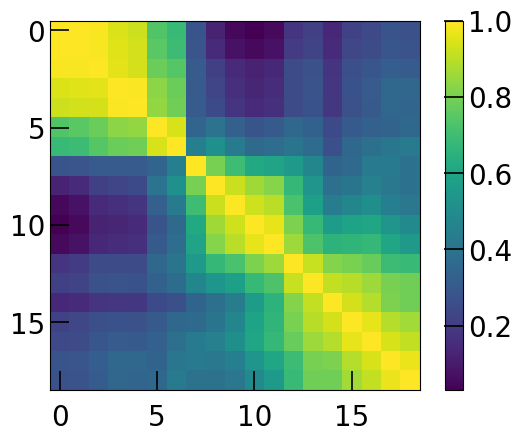

In [69]:
plt.imshow(correlation[:,:,0])
plt.colorbar()
plt.show()

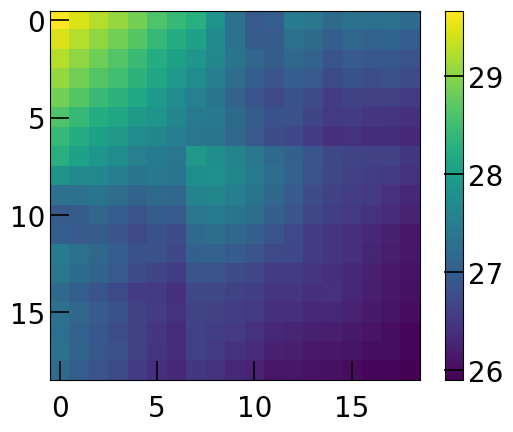

In [70]:
plt.imshow(np.log10(covariance[:,:,0]))
plt.colorbar()
plt.show()

In [71]:
err = np.std(covariance,axis=2)
mean = np.mean(covariance,axis=2)
rel_err = err/mean

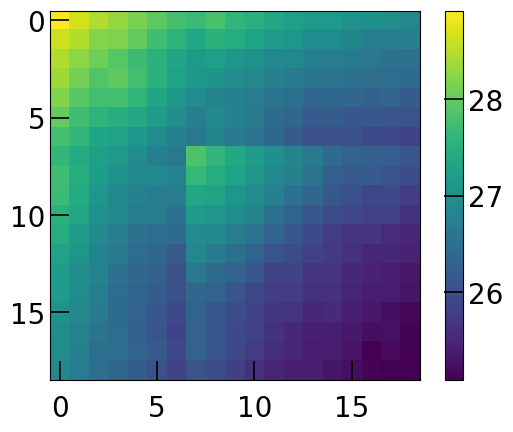

In [72]:
plt.imshow(np.log10(err))
plt.colorbar()
plt.show()

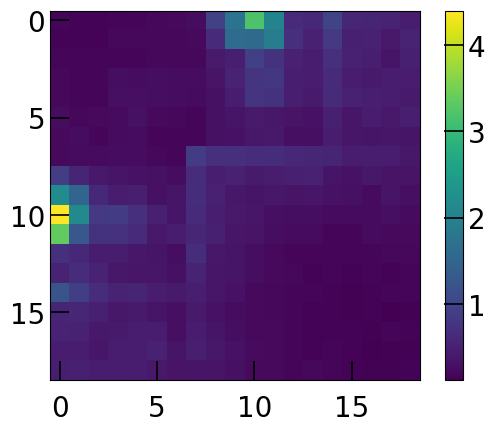

In [74]:
plt.imshow(rel_err)
plt.colorbar()
plt.show()

In [75]:
for i in range(len(rel_err)):
    print(rel_err[i,i])

0.18118011163886794
0.16424757612504073
0.18340791799316222
0.2800082863134723
0.29465066557483205
0.22649620079901656
0.1803615669495605
0.8846881547613633
0.4693134448727031
0.3857322125813914
0.37816108693785383
0.2743924568922681
0.1966288769197371
0.16486991184012403
0.1640246935698909
0.1381648243746476
0.1467124074831585
0.1472814510304195
0.1565389807131209
